In [82]:
import numpy as np
import meshplot as mp
import results.runs as runs
import os
import matplotlib.pyplot as plt
import torch
import model.sdf_model as sdf_model
import trimesh

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Training curves

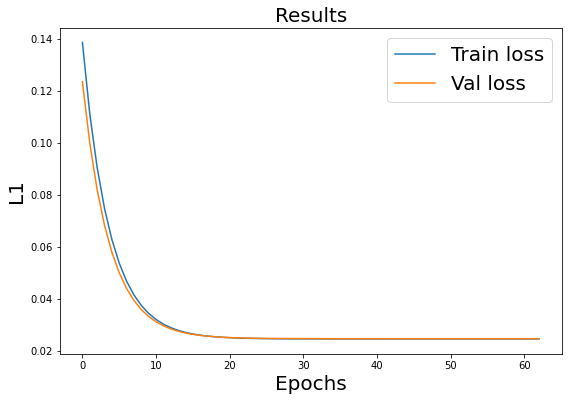

In [83]:
run_folder = '04_11_161003'
run_dir = os.path.join(os.path.dirname(runs.__file__), run_folder)
results_path = os.path.join(run_dir, 'results.npy')
results = np.load(results_path, allow_pickle=True).item()

train_loss = results['train']['loss']
val_loss = results['val']['loss']
plt.figure(figsize=(9, 6))
plt.title('Results', fontsize=20)
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('L1', fontsize=20) 
plt.legend(fontsize=20)
plt.show()

Extract latent code:

In [70]:
latent_codes = torch.tensor(results['train']['latent_codes'][-1])     # last one

# Visualize mesh
First optimised latent code during training:

In [81]:
latent_code_idx = 2
run_folder = '04_11_161003'
run_dir = os.path.join(os.path.dirname(runs.__file__), run_folder)
weights_path = os.path.join(run_dir, 'weights.pt')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def extract_mesh(data, sdf):
    sdf_inside = data[(sdf.view(-1)>-0.01) & (sdf.view(-1)<0.01)]
    #sdf_inside = data[(sdf.view(-1)<0.01)]
    mesh = trimesh.voxel.ops.points_to_marching_cubes(sdf_inside.detach().cpu().numpy(), pitch=0.015)
    return mesh

model = sdf_model.SDFModelMulti().to(device)
model.load_state_dict(torch.load(weights_path, map_location=torch.device(device)))
model.eval()
grid_values = torch.arange(-1, 1, 0.1) #0.015
grid = torch.meshgrid(grid_values, grid_values, grid_values)
coords = torch.vstack((grid[0].ravel(), grid[1].ravel(), grid[2].ravel())).transpose(1, 0).to(device)
latent_tile = torch.tile(latent_codes[latent_code_idx, :], (coords.shape[0], 1))
coords_latent = torch.hstack((latent_tile, coords))
print(sdf)
with torch.no_grad():
    sdf = model(coords_latent)
mesh = extract_mesh(coords, sdf)
verts = np.asarray(mesh.vertices)
faces = np.asarray(mesh.faces)

tensor([[-0.0002],
        [-0.0002],
        [-0.0002],
        ...,
        [-0.0003],
        [-0.0003],
        [-0.0003]])
tensor([True, True, True,  ..., True, True, True])


In [79]:
shading={'wireframe':False, "colormap": "viridis"}
#mp.plot(sphere_verts, sphere_faces, c=sphere_verts[:, 1], shading=shading)
mp.plot(verts, faces, c=verts[:, 1], shading=shading)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.047500…